In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [2]:
%ls '/gdrive/My Drive/External Projects/chest/'
BASE_PATH = '/gdrive/My Drive/External Projects/chest/'

A2_GradCAM.ipynb     A2_TL_Resnet.ipynb  A3_TL_MobileNet.ipynb  weights/
A2_GradCAM_pp.ipynb  A2_xGradCAM.ipynb   archive.zip


In [3]:
import zipfile as zf  
files = zf.ZipFile(BASE_PATH+"archive.zip", 'r')
files.extractall()
files.close()

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import os
import torch  
base_dir = "chest_xray/chest_xray" 

In [5]:
from torchvision import transforms
image_transforms = {
    'train':
    transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),  
        transforms.ToTensor(),
    ]),
    'test':
    transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
    ]),
}

In [6]:
from torchvision.datasets import ImageFolder

train_ds = ImageFolder(root=os.path.join(base_dir,"train"), transform=image_transforms['train'])
test_ds = ImageFolder(root=os.path.join(base_dir,"test"), transform=image_transforms['test'])
print(len(train_ds), len(test_ds))
class_names = train_ds.classes
print(class_names)

5216 624
['NORMAL', 'PNEUMONIA']


In [7]:
from torch.utils.data.dataloader import DataLoader

batch_size = 32

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=1, pin_memory=True)
test_dl = DataLoader(test_ds, batch_size, num_workers=1, pin_memory=True)

device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda")

In [ ]:
images, labels = iter(train_dl).next()
images.shape

torch.Size([32, 3, 224, 224])

In [8]:
import torchvision.models as models
net = models.mobilenet_v3_small(pretrained=True)

Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth


In [9]:
import torch.nn as nn

net.classifier = nn.Sequential(
    nn.Linear(576, 512),
    nn.BatchNorm1d(512),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(512,2),
)
net.load_state_dict(torch.load("/gdrive/My Drive/External Projects/chest/weights/model_2.pt"))
net = net.to(device)
print(net)

MobileNetV3(
  (features): Sequential(
    (0): ConvBNActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (relu): ReLU(inplace=True)
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
        )
        (2): ConvBNActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_r

In [10]:
for param in net.parameters():
    param.requires_grad = False

i = 0
for child in net.children():
  for c in child.children():
    if i >= 11:
      for param in c.parameters():
        param.requires_grad = True
    i += 1

# for param in net.classifier.parameters():
#     param.requires_grad = True

In [11]:
import torch.optim as optim
from sklearn.metrics import confusion_matrix
import seaborn as sns
weights = [1.0, .5]
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
class_weights = torch.FloatTensor(weights).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights).to(device)
optimizer = optim.SGD(net.parameters(), lr=0.005, momentum=0.9)
net = net.to(device)
EPOCHS = 100
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [12]:
all_train_metrics = []
all_test_metrics = []

In [13]:
def evaluate(true_labels, pred_labels):
    cm = confusion_matrix(true_labels, pred_labels)
    tn, fp, fn, tp = cm.ravel()
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    accuracy = (tp+tn)/(tn+fp+fn+tp)
    return precision, recall, accuracy

best_acc = 0
for epoch in range(EPOCHS): 
    net.train()
    true_labels = []
    pred_labels = []
    for i, (inputs, labels) in enumerate(train_dl, 0):
        true_labels += [t.cpu().numpy() for t in labels]
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        
        pred_labels += [p.cpu().numpy() for p in predicted]
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # scheduler.step()
 
    precision, recall, accuracy = evaluate(true_labels, pred_labels)
    all_train_metrics.append({"pres":precision, "recall":recall, "acc": accuracy})
    if (epoch % 10 == 0):
      print("Train Epoch: {} Pres: {:.2f} Recall: {:.2f} Acc: {:.2f}".format(epoch, precision, recall, accuracy))

    net.eval()
    true_labels = []
    pred_labels = []
    for i, (inputs, labels) in enumerate(test_dl, 0):
        true_labels += [t.cpu().numpy() for t in labels]
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        pred_labels += [p.cpu().numpy() for p in predicted]

    precision, recall, accuracy = evaluate(true_labels, pred_labels)
    all_test_metrics.append({"pres":precision, "recall":recall, "acc": accuracy})
    if (epoch % 10 == 0):
      print("Test  Epoch: {} Pres: {:.2f} Recall: {:.2f} Acc: {:.2f}".format(epoch, precision, recall, accuracy))

    if accuracy > best_acc:
      print()
      print("Test  Epoch: {} Pres: {:.2f} Recall: {:.2f} Acc: {:.2f}".format(epoch, precision, recall, accuracy))
      print("Saved Model")
      print()
      torch.save(net.state_dict(),"/gdrive/My Drive/External Projects/chest/weights/model_2.pt")
      best_acc = accuracy
print('Finished Training')

Train Epoch: 0 Pres: 0.99 Recall: 0.98 Acc: 0.98
Test  Epoch: 0 Pres: 0.85 Recall: 0.99 Acc: 0.89

Test  Epoch: 0 Pres: 0.85 Recall: 0.99 Acc: 0.89
Saved Model


Test  Epoch: 3 Pres: 0.86 Recall: 0.99 Acc: 0.90
Saved Model

Train Epoch: 10 Pres: 0.99 Recall: 0.99 Acc: 0.99
Test  Epoch: 10 Pres: 0.85 Recall: 0.99 Acc: 0.88

Test  Epoch: 18 Pres: 0.88 Recall: 0.98 Acc: 0.91
Saved Model


Test  Epoch: 19 Pres: 0.90 Recall: 0.98 Acc: 0.92
Saved Model

Train Epoch: 20 Pres: 0.99 Recall: 0.99 Acc: 0.98
Test  Epoch: 20 Pres: 0.86 Recall: 0.99 Acc: 0.89
Train Epoch: 30 Pres: 1.00 Recall: 0.99 Acc: 0.99
Test  Epoch: 30 Pres: 0.84 Recall: 0.99 Acc: 0.88
Train Epoch: 40 Pres: 1.00 Recall: 0.99 Acc: 0.99
Test  Epoch: 40 Pres: 0.85 Recall: 0.99 Acc: 0.89
Train Epoch: 50 Pres: 1.00 Recall: 0.99 Acc: 0.99
Test  Epoch: 50 Pres: 0.83 Recall: 0.99 Acc: 0.87
Train Epoch: 60 Pres: 1.00 Recall: 0.99 Acc: 0.99
Test  Epoch: 60 Pres: 0.88 Recall: 0.98 Acc: 0.91
Train Epoch: 70 Pres: 1.00 Recall: 0.99 Acc: 0.9

In [14]:
# torch.save(net.state_dict(),"/gdrive/My Drive/External Projects/chest/weights/model_1.pt")
import pickle
pickle.dump(all_train_metrics,open("/gdrive/My Drive/External Projects/chest/weights/train_metrics_2.pkl",'wb'))
pickle.dump(all_test_metrics,open("/gdrive/My Drive/External Projects/chest/weights/test_metrics_2.pkl",'wb'))

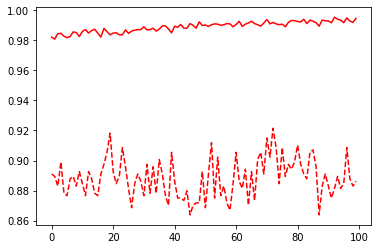

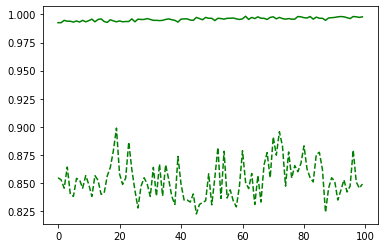

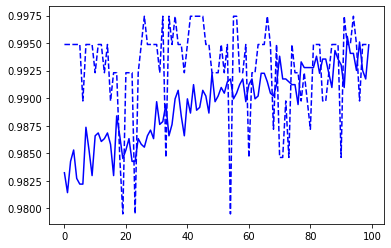

In [15]:
import matplotlib.pyplot as plt

plt.plot([metrics["acc"] for metrics in all_train_metrics], 'r-')
plt.plot([metrics["acc"] for metrics in all_test_metrics], 'r--')
plt.show()

plt.plot([metrics["pres"] for metrics in all_train_metrics], 'g-')
plt.plot([metrics["pres"] for metrics in all_test_metrics], 'g--')
plt.show()

plt.plot([metrics["recall"] for metrics in all_train_metrics], 'b-')
plt.plot([metrics["recall"] for metrics in all_test_metrics], 'b--')
plt.show()